In [1]:
UPDATE = "asynchronous"
DIRECTORY = "models/random_nk3"
NUM_RUNS = 100
DEBUG = True

In [2]:
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg

from transition_matrix import get_transition_matrix, get_markov_chain
from matrix_operations import compress_matrix
from grouping import sd_grouping
from paths import get_all_paths, get_markov_chain_path_probs, get_stg_path_probs, get_random_path_probs
from paths import compare_path_reachability, compare_path_rmsd

def get_data(bnet, data = {}, update="asynchronous", num_runs=100, DEBUG = False):

    # initialize data
    data["paths_reachability"] = {}
    data["paths_rmsd"] = {}
    
    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}
    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return data
    stg = primes2stg(percolated_primes, update)
    percolated_bnet = primes2bnet(percolated_primes)

    # Get the transition matrix
    T = get_transition_matrix(stg, DEBUG=DEBUG)

    # Get path probabilities for the sd grouped transition matrix
    sd_indexes = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indexes, DEBUG=DEBUG)
    sd_markov_chain = get_markov_chain(Tsd, sd_indexes, DEBUG=DEBUG)
    sd_all_paths = get_all_paths(sd_markov_chain, DEBUG=DEBUG)
    sd_markov_chain_path_probs = get_markov_chain_path_probs(sd_markov_chain, sd_all_paths, DEBUG=DEBUG)
    sd_stg_path_probs = get_stg_path_probs(sd_all_paths, sd_indexes, stg, T, DEBUG=DEBUG)

    # Get comparison results
    data["paths_reachability"]["sd_all"] = compare_path_reachability(sd_stg_path_probs, sd_markov_chain_path_probs, type="all", DEBUG=DEBUG)
    data["paths_reachability"]["sd_edges"] = compare_path_reachability(sd_stg_path_probs, sd_markov_chain_path_probs, type="edges", DEBUG=DEBUG)
    data["paths_reachability"]["sd_non_edges"] = compare_path_reachability(sd_stg_path_probs, sd_markov_chain_path_probs, type="non_edges", DEBUG=DEBUG)

    data["paths_rmsd"]["sd_all"] = compare_path_rmsd(sd_stg_path_probs, sd_markov_chain_path_probs, type="all", DEBUG=DEBUG)
    data["paths_rmsd"]["sd_edges"] = compare_path_rmsd(sd_stg_path_probs, sd_markov_chain_path_probs, type="edges", DEBUG=DEBUG)
    data["paths_rmsd"]["sd_non_edges"] = compare_path_rmsd(sd_stg_path_probs, sd_markov_chain_path_probs, type="non_edges", DEBUG=DEBUG)

    # Get path rmsd for randomized markov chains
    data["paths_rmsd"]["sd_all_randomized"] = []
    data["paths_rmsd"]["sd_edges_randomized"] = []
    data["paths_rmsd"]["sd_non_edges_randomized"] = []

    for i in range(num_runs):
        random_path_probs = get_random_path_probs(sd_markov_chain_path_probs, seed=i)
        data["paths_rmsd"]["sd_all_randomized"].append(compare_path_rmsd(sd_stg_path_probs, random_path_probs, type="all", DEBUG=DEBUG))
        data["paths_rmsd"]["sd_edges_randomized"].append(compare_path_rmsd(sd_stg_path_probs, random_path_probs, type="edges", DEBUG=DEBUG))
        data["paths_rmsd"]["sd_non_edges_randomized"].append(compare_path_rmsd(sd_stg_path_probs, random_path_probs, type="non_edges", DEBUG=DEBUG))

    return data

In [3]:
import os
import numpy as np

# np.set_printoptions(linewidth=10000, threshold=1000000, precision=3, suppress=False)

all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(DIRECTORY)):

    file_path = os.path.join(DIRECTORY, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
        
    data = get_data(bnet=content, data={}, update="asynchronous", num_runs=1, DEBUG=True)

    all_data[filename] = data

Reading file: n010_000.bnet
Reading file: n010_001.bnet
Reading file: n010_002.bnet
Reading file: n010_003.bnet
Reading file: n010_004.bnet
duplicates={'000000001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000000101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000000111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000010100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010110': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000100001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000100100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], 

In [4]:
import numpy as np

for bnet in all_data:
    if len(all_data[bnet]["paths_reachability"]) == 0:
        continue
    print(bnet,
          all_data[bnet]["paths_reachability"]["sd_all"][0],
          all_data[bnet]["paths_reachability"]["sd_all"][1],
          all_data[bnet]["paths_reachability"]["sd_all"][2],
          all_data[bnet]["paths_reachability"]["sd_all"][3],

          all_data[bnet]["paths_reachability"]["sd_edges"][0],
          all_data[bnet]["paths_reachability"]["sd_edges"][1],
          all_data[bnet]["paths_reachability"]["sd_edges"][2],
          all_data[bnet]["paths_reachability"]["sd_edges"][3],

          all_data[bnet]["paths_reachability"]["sd_non_edges"][0],
          all_data[bnet]["paths_reachability"]["sd_non_edges"][1],
          all_data[bnet]["paths_reachability"]["sd_non_edges"][2],
          all_data[bnet]["paths_reachability"]["sd_non_edges"][3],

          all_data[bnet]["paths_rmsd"]["sd_all"],
          all_data[bnet]["paths_rmsd"]["sd_edges"],
          all_data[bnet]["paths_rmsd"]["sd_non_edges"],

          np.mean(all_data[bnet]["paths_rmsd"]["sd_all_randomized"]),
          np.mean(all_data[bnet]["paths_rmsd"]["sd_edges_randomized"]),
          np.mean(all_data[bnet]["paths_rmsd"]["sd_non_edges_randomized"])
          )

n010_000.bnet 126 0 0 0 30 0 0 0 96 0 0 0 0.0446424398799345 0.04891154641342499 0.043221955751924966 0.20851414319377956 0.26813628310992743 0.18600332230710975
n010_001.bnet 36 0 0 0 20 0 0 0 16 0 0 0 0.08102695952597502 0.09269608732578953 0.06349309116483458 0.127633864954429 0.1595878475609594 0.06941222137193966
n010_002.bnet 15 0 0 0 7 0 0 0 8 0 0 0 0.16036983133487165 0.1715815670143574 0.14987311427583958 0.2612621034620445 0.29026430889132193 0.23294170876747342
n010_003.bnet 4 0 0 0 3 0 0 0 1 0 0 0 0.0009757231224729118 0.0009199205819547289 0.0011266680148124264 0.2767639850174655 0.27066644879126095 0.29429956525141987
n010_004.bnet 386 0 0 0 77 0 0 0 309 0 0 0 0.0756774244520679 0.09659599847709303 0.06949143552030884 0.12742008276755143 0.2092622480457889 0.09679601380065678
n010_005.bnet 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.0 0.0 0.0
n010_006.bnet 882 0 0 0 60 0 0 0 822 0 0 0 0.053092859428145116 0.10497189053801863 0.047119991661333724 0.08488092626255876 0.2126247550190838

In [5]:
import matplotlib.pyplot as plt

def plot_precision_and_recall(TP, FP, TN, FN):

    # Lists to store precision and recall values
    precisions = []
    recalls = []

    # Calculate precision and recall for each set of values
    for i in range(len(TP)):
        tp = TP[i]
        fp = FP[i]
        tn = TN[i]
        fn = FN[i]
        
        # Calculate precision and recall
        if tp + fp != 0:
            precision = tp / (tp + fp)
            precisions.append(precision)
        if tp + fn != 0:
            recall = tp / (tp + fn)
            recalls.append(recall)
            
    # Create histograms of precision and recall
    plt.figure(figsize=(10, 6))

    # Plotting the histogram for Precision
    plt.subplot(1, 2, 1)
    plt.hist(precisions, bins=10, color='blue', alpha=0.7)
    plt.title('Precision Histogram')
    plt.xlabel('Precision')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Plotting the histogram for Recall
    plt.subplot(1, 2, 2)
    plt.hist(recalls, bins=10, color='green', alpha=0.7)
    plt.title('Recall Histogram')
    plt.xlabel('Recall')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

142.01098901098902 0.07692307692307693 0.0 0.0


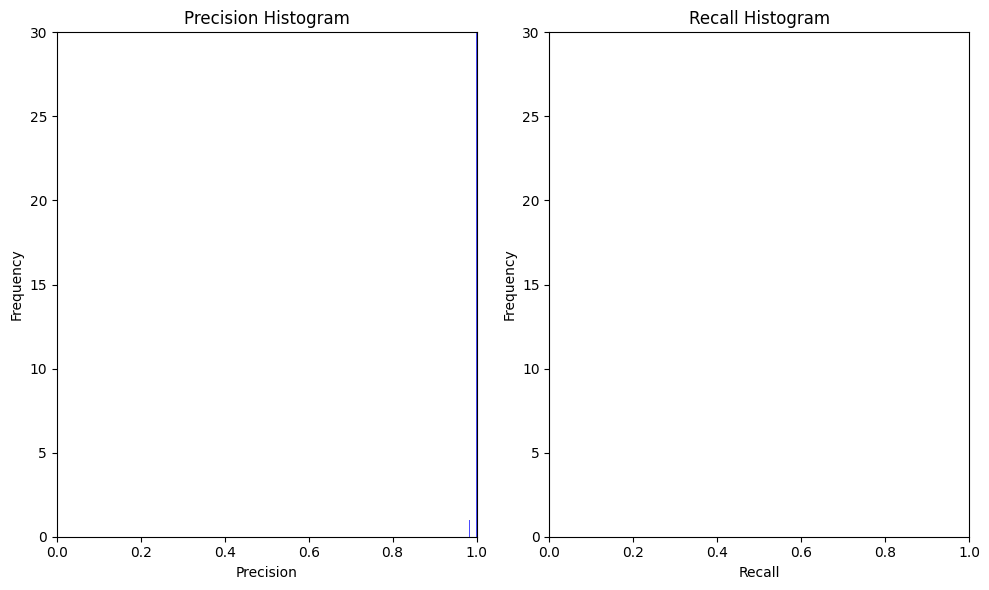

In [6]:
TP = []
FP = []
TN = []
FN = []
for bnet in all_data:
    if len(all_data[bnet]["paths_reachability"]) == 0:
        continue
    TP.append(all_data[bnet]["paths_reachability"]["sd_all"][0])
    FP.append(all_data[bnet]["paths_reachability"]["sd_all"][1])
    TN.append(all_data[bnet]["paths_reachability"]["sd_all"][2])
    FN.append(all_data[bnet]["paths_reachability"]["sd_all"][3])

print(np.mean(TP), np.mean(FP), np.mean(TN), np.mean(FN))

plot_precision_and_recall(TP, FP, TN, FN)

126.68131868131869 0.07692307692307693 0.0 0.0


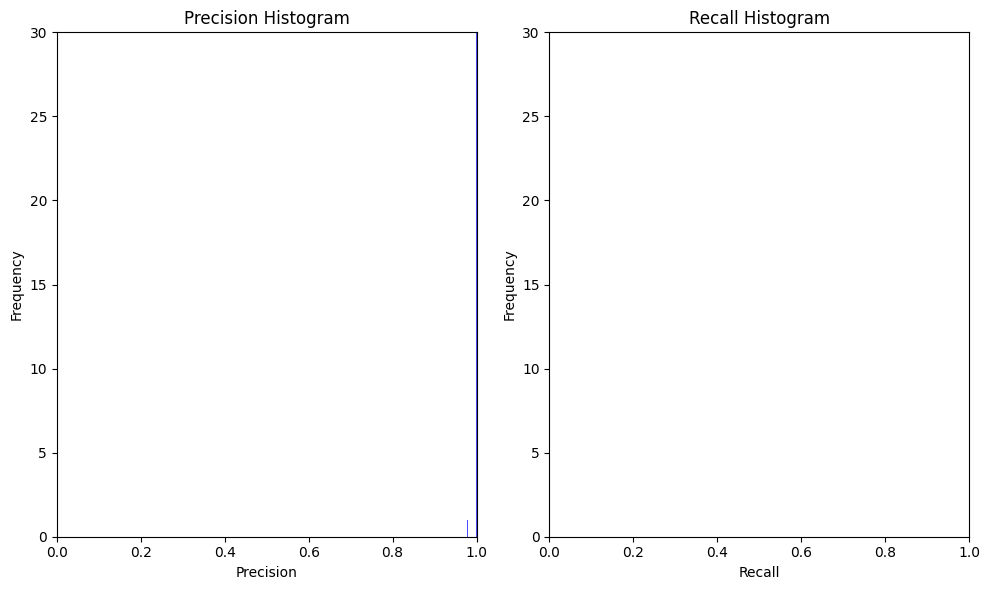

In [7]:
TP = []
FP = []
TN = []
FN = []
for bnet in all_data:
    if len(all_data[bnet]["paths_reachability"]) == 0:
        continue
    TP.append(all_data[bnet]["paths_reachability"]["sd_non_edges"][0])
    FP.append(all_data[bnet]["paths_reachability"]["sd_non_edges"][1])
    TN.append(all_data[bnet]["paths_reachability"]["sd_non_edges"][2])
    FN.append(all_data[bnet]["paths_reachability"]["sd_non_edges"][3])

print(np.mean(TP), np.mean(FP), np.mean(TN), np.mean(FN))

plot_precision_and_recall(TP, FP, TN, FN)